# Intro

## The Blocker Fraud Company

**Blocker Fraud Company** is a specialized company in fraud detection on financial transactions through mobile devices. It has the "Blocker Fraud" service, which guarantee the block of fraudulent transactions.

The company business model is service type, with monetization made by performance of the provided service. The user pay a fixed fee on the fraud detection success.

## Expansion Strategy in Brazil

Aiming to expand business in Brazil it has adopted the following strategy:

- The company will receive 25% of the value of each transaction detected as *fraud*.
- The company will receive 5% of the value of each transaction detected as *fraud*, but the transaction is *legitimate*.
- The company will return 100% of the value to the customer, for each transaction detected as legitimate, however a transaction is a fraud.

## Context

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behavior to later evaluate the performance of fraud detection methods.

## Content

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

## Goal

1. What is the model's *precision* and *accuracy*?
2. How reliable is the model in classifying transactions as *legitimate* or *fraudulent*?
3. What is the expected billing by the company if we classify 100% of data transactions with the model?
4. What is the loss expected by company in case of model failure ?
5. What is the profit expected by the **Blocker Fraud Company** when using model?
> Disclaimer: The following context is completely fictional, the company, the context, the CEO and the business questions.

## Data

Data provided by Kaggle: [Synthetic Financial Datasets for Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1)

## Analysis

This solution will use descriptive statistics and data visualization to find key figures in understanding the distribution, count, and relationship between variables. Since the goal of the project to make predictions on the fraud's detection, classification algorithms from the supervised learning family of machine learning models will be implemented.

## Evaluation

The project will conclude with the evaluation of the machine learning model selected with a validation data set. The output of the predictions can be checked through a confusion matrix, and metrics such as accuracy, precision, recall, F1 and Kappa scores.

# 0.0. Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Statistics
from scipy import stats
from pandas_profiling import ProfileReport

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Load images
from IPython.display import Image

# Text edit
import inflection

# Warning
import warnings
warnings.filterwarnings( 'ignore' )

# Feature selection
from boruta import BorutaPy

# Stats
from scipy import stats

# Scalers
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder

# Save files
import pickle

# Model selection
from sklearn.model_selection import train_test_split

# Machine Learning models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# Model's cross-validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV,\
GridSearchCV

# Model's metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, classification_report, auc

# Handling Oversampling
from imblearn.over_sampling import SMOTE 

## 0.1. Help Functions

In [2]:
# Percentual plot
def percentual_count(var: str, dataset: pd.DataFrame):
    ax = sns.countplot(y=var, data=dataset)
    total = len(dataset[var])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    return plt.show()

In [3]:
# Checking outliers function:
def drop_outliers(var: str, dataset: pd.DataFrame):

    # find Q1, Q3 e IQR
    Q1 = np.quantile(dataset[var], .25)
    Q3 = np.quantile(dataset[var], .75)
    IQR = Q3 - Q1

    # calculates the outliers boundaries through statistical relationship
    high = Q3 + 1.5 * IQR

    return print(f'For {var} the high outliers {high}')

In [4]:
# Model's performance
def ml_scores(model_name, y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    
    return pd.DataFrame({'Accuracy': accuracy, 
                         'Precision': precision, 
                         'Recall': recall,
                         'F1': f1,
                         'ROC': roc}, 
                        index=[model_name])

In [ ]:
# Confusion Matrix function
def conf_matrix(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    cm_data = pd.DataFrame(cm, columns = ['Positive', 'Negative'], index=['Positive', 'Negative'])
    sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='d', annot_kws={'size': 24}).set_title('Confusion Matrix')

    return plt.show()

In [ ]:
# Model's performance function
def cross_val_performance(model, y_train, y_pred):
    # define scoring metrics
    scoring = {'Accuracy': 'accuracy',
               'Precision': make_scorer(precision_score),
               'Recall': make_scorer(recall_score),
               'F1': make_scorer(f1_score),
               'ROC': make_scorer(roc_auc_score)}

    # calculate scores with cross_validate
    scores = cross_validate(model, y_train, y_pred, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean().astype(str) + ' +/- ' + (performance.std()*2).astype(str)).T
    return performance

# 1.0. Data

## 1.1. Load the Data

In [2]:
df = pd.read_csv('data\PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1.2. Knowing the Data

### 1.2.1. Shape

In [3]:
print('The shape of dataset is:')
df.shape

The shape of dataset is:


(6362620, 11)

### 1.2.2. Type and Structure

In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


* It's a huge dataset with memory usage more than 534.0 MB.
* No null values.
* dtypes: float64(5), int64(3), object(3)

### 1.2.3. Columns Description
| Feature        | Description                                                  |
| :------------- | :----------------------------------------------------------- |
| step           | maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation). |
| type           | Transaction type (CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER) |
| amount         | amount of the transaction in local currency                  |
| nameOrig       | customer who started the transaction                         |
| oldbalanceOrg  | initial balance before the transaction                       |
| newbalanceOrig | new balance after the transaction                            |
| nameDest       | customer who is the recipient of the transaction             |
| oldbalanceDest | initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants) |
| newbalanceDest | new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants) |
| isFraud        | This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system |
| isFlaggedFraud | The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200K in a single transaction |

## 1.3. Dtypes changes
In order do optimize the RAM usage, we're going to specify the data types that we want for each feature

In [5]:
# defines a dictionary of dtypes for each feature
feature_dtypes = {'step': 'int16',
                  'type': 'category',
                  'amount': 'float32',
                  'nameOrig': 'object',
                  'oldbalanceOrg': 'float32',
                  'newbalanceOrig': 'float32',
                  'nameDest': 'object',
                  'oldbalanceDest': 'float32',
                  'newbalanceDest': 'float32',
                  'isFraud': 'uint8',
                  'isFlaggedFraud': 'uint8'}

# Load the data
df_op = pd.read_csv('data\PS_20174392719_1491204439457_log.csv', dtype=feature_dtypes)

In [6]:
df_op.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   step            6362620 non-null  int16   
 1   type            6362620 non-null  category
 2   amount          6362620 non-null  float32 
 3   nameOrig        6362620 non-null  object  
 4   oldbalanceOrg   6362620 non-null  float32 
 5   newbalanceOrig  6362620 non-null  float32 
 6   nameDest        6362620 non-null  object  
 7   oldbalanceDest  6362620 non-null  float32 
 8   newbalanceDest  6362620 non-null  float32 
 9   isFraud         6362620 non-null  uint8   
 10  isFlaggedFraud  6362620 non-null  uint8   
dtypes: category(1), float32(5), int16(1), object(2), uint8(2)
memory usage: 248.8+ MB


- The memory usage reduce to 248.8.0 MB.
- Still no null values.
- dtypes: category(1), float32(5), int16(1), object(2), uint8(2)

## 1.4. Rename Columns

In [7]:
# Using underscore
cols_list = []
for x in df_op.columns:
    columns_new = inflection.underscore(x)
    cols_list.append(columns_new)

In [8]:
df_op.columns = cols_list
df_op = df_op.rename(columns={'oldbalance_org': 'oldbalance_orig' })
df_op

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9.839640e+03,C1231006815,170136.000,160296.359375,M1979787155,0.000000e+00,0.000,0,0
1,1,PAYMENT,1.864280e+03,C1666544295,21249.000,19384.720703,M2044282225,0.000000e+00,0.000,0,0
2,1,TRANSFER,1.810000e+02,C1305486145,181.000,0.000000,C553264065,0.000000e+00,0.000,1,0
3,1,CASH_OUT,1.810000e+02,C840083671,181.000,0.000000,C38997010,2.118200e+04,0.000,1,0
4,1,PAYMENT,1.166814e+04,C2048537720,41554.000,29885.859375,M1230701703,0.000000e+00,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,3.396821e+05,C786484425,339682.125,0.000000,C776919290,0.000000e+00,339682.125,1,0
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.000000,C1881841831,0.000000e+00,0.000,1,0
6362617,743,CASH_OUT,6.311410e+06,C1162922333,6311409.500,0.000000,C1365125890,6.848884e+04,6379898.000,1,0
6362618,743,TRANSFER,8.500025e+05,C1685995037,850002.500,0.000000,C2080388513,0.000000e+00,0.000,1,0


## 1.6. Descriptive Statistics

### 1.6.1. Numerical Attributes

In [9]:
# Selecting numerical attributes
num_attr = df_op.select_dtypes(exclude=['category', 'object'])

# Describe
describe = num_attr.describe().T

describe['range'] = (num_attr.max() - num_attr.min()).tolist()
describe['unique val.'] = num_attr.nunique()
describe['variation coefficient'] = np.round((num_attr.std() / num_attr.mean()), 4).tolist()
describe['skew'] = np.round(num_attr.skew(), 4).tolist()
describe['kurtosis'] = np.round(num_attr.kurtosis(), 4).tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,unique val.,variation coefficient,skew,kurtosis
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.000000,239.000000,3.350000e+02,743.0,742.0,743,0.5848,0.3752,0.3291
amount,6362620.0,1.779883e+05,5.991358e+05,0.0,13389.570312,74871.937500,2.087215e+05,92445520.0,92445520.0,5236933,3.3662,30.9939,1797.9567
oldbalance_orig,6362620.0,8.246191e+05,2.831753e+06,0.0,0.000000,14208.000000,1.073152e+05,59585040.0,59585040.0,1834373,3.4340,5.2491,32.9649
newbalance_orig,6362620.0,8.503204e+05,2.862818e+06,0.0,0.000000,0.000000,1.442584e+05,49585040.0,49585040.0,2663280,3.3668,5.1769,32.0670
oldbalance_dest,6362620.0,1.097866e+06,3.369338e+06,0.0,0.000000,132705.664062,9.430367e+05,356015904.0,356015904.0,3532215,3.0690,19.9218,948.6741
newbalance_dest,6362620.0,1.221764e+06,3.629806e+06,0.0,0.000000,214661.445312,1.111909e+06,356179264.0,356179264.0,3474507,2.9710,19.3523,862.1565
is_fraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.000000,0.000000,0.000000e+00,1.0,1.0,2,27.8155,27.7795,769.7030
is_flagged_fraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.000000,0.000000,0.000000e+00,1.0,1.0,2,630.6051,630.6036,397659.0625


Exception of `step` feature, most of the numerical attributes shows:

* High skew.
* High kurtosis.
* High variation.

### 1.6.2. Categorical Attributes

In [10]:
cat_attr = df_op.select_dtypes(include=['category', 'object'])
cat_attr.describe().T

,count,unique,top,freq
type,6362620,5,CASH_OUT,2237500
name_orig,6362620,6353307,C1065307291,3
name_dest,6362620,2722362,C1286084959,113


## 1.7. Checkpoint A

In [11]:
# Saving optimize dataset
df_op.to_csv('dataset\df1.csv', index=False)

# 2.0. Hypotheses Creation

## 2.1. Mind Map Hypotheses

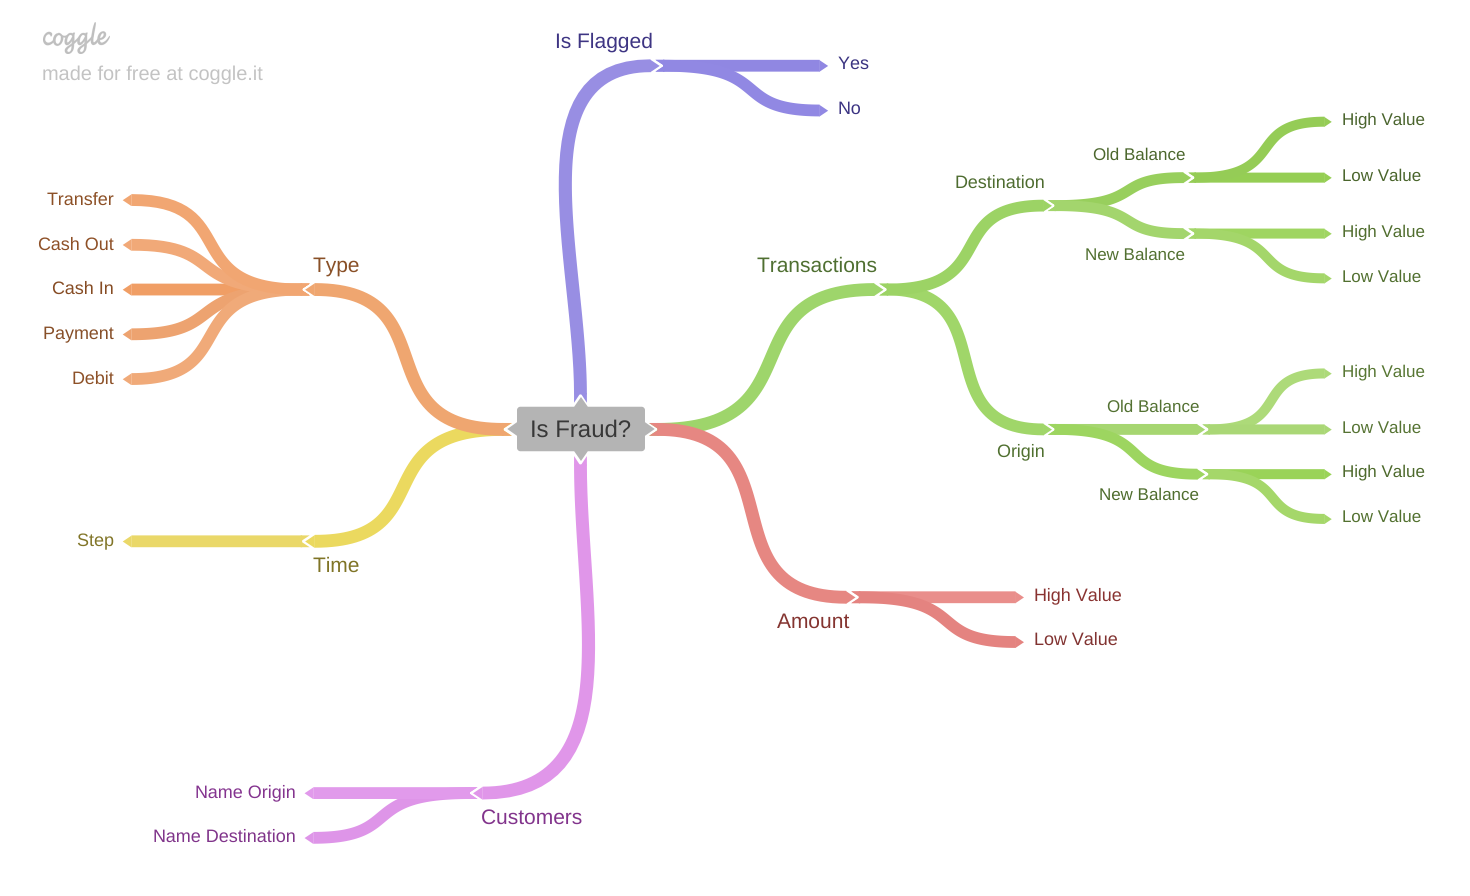

In [12]:
Image('image\mindmap.png')

## 2.2. Hypotheses Creation

### 2.2.1. Type

h1. Frauds occur with 3 types of transactions.

### 2.2.2. Amount

h1. Fraud occur with low values amounts.

### 2.2.3. Transactions

h1. Fraud occur with high values of old balance origin.

h2. Fraud occur with new balance origin is equal zero.

h3. Fraud occur with low values old balance destination.

h4. All fraudulent transaction occur with new receiver balance  equal zero.

### 2.2.4. Customers

h1. Customer to customer transactions represent 50% of the total fraudulent transactions.

h2. Merchant receiver represents 40% of the total fraudulent transactions.

### 2.2.5. Time

h1. Most Fraud occurs between days 10 and 20.

### 2.2.6. Is Flagged

h1. All flagged frauds represent 90% of frauds transactions.

## 2.3. Hyphoteses List

| #    | HYPOTHESES                                                   |
| ---- | ------------------------------------------------------------ |
| h1   | Frauds occur with 3 types of transfers.                      |
| h2   | Fraud occur with low values amounts.                         |
| h3   | Fraud occur with high values of old origin balance.          |
| h4   | Fraud occur with new balance origin is equal zero.           |
| h5   | Fraud occur with low values old balance destination.         |
| h6   | All fraudulent transaction occur with new receiver balance equal zero. |
| h7   | Customer to customer transactions represent 50% of the total fraudulent transactions. |
| h8   | Merchant receiver represents 40% of the total fraudulent transactions. |
| h9   | Most Fraud occurs between days 10 and 20.                                 |
|h10  | All flagged frauds represent 90% of frauds transactions. |

# 3.0. Feature Engineering
Theoretically, the difference between a previous transaction and a subsequent one would be equal to the total transferred:

>amount = oldbalanceOrg - newbalanceOrig

The same could be said for Destinations:

>newbalanceDest = amount + oldbalanceDest

In [2]:
# Load dataset
feature_dtypes = {'step': 'int16',
                  'type': 'category',
                  'amount': 'float32',
                  'nameOrig': 'object',
                  'oldbalanceOrg': 'float32',
                  'newbalanceOrig': 'float32',
                  'nameDest': 'object',
                  'oldbalanceDest': 'float32',
                  'newbalanceDest': 'float32',
                  'isFraud': 'uint8',
                  'isFlaggedFraud': 'uint8'}

df1 = pd.read_csv('dataset\df1.csv', dtype=feature_dtypes)

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Origin balance
df1['error_orig'] = df1.oldbalance_orig - df1.newbalance_orig - df1.amount

# Destination balance
df1['error_dest'] = df1.oldbalance_dest + df1.amount - df1.newbalance_dest

A new feature classifying the type of customers.

In [4]:
# Customer type for name origin
# df1['orig_type'] = df1['name_orig'].str.replace(r'[0-9]', regex=True, repl='')

# Customer type for name destination
df1['dest_type'] = df1['name_dest'].str.replace(r'[0-9]', regex=True, repl='')

The `orig_type` feature has only one customer type, that column will be removed.

In [5]:
df1.dest_type.value_counts()

C    4211125
M    2151495
Name: dest_type, dtype: int64

Feature day will be created in order to ease the analysis.

In [6]:
# Day column
df1['days'] = df1.step.apply(lambda x: np.ceil(x/24).astype('int'))

In [11]:
# Saving dataset
df1.to_csv('dataset\df2.csv', index=False)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
 #   Column            Dtype   
---  ------            -----   
 0   step              int16   
 1   type              category
 2   amount            float32 
 3   name_orig         object  
 4   oldbalance_orig   float64 
 5   newbalance_orig   float64 
 6   name_dest         object  
 7   oldbalance_dest   float64 
 8   newbalance_dest   float64 
 9   is_fraud          int64   
 10  is_flagged_fraud  int64   
 11  error_orig        float64 
 12  error_dest        float64 
 13  dest_type         object  
 14  days              int64   
dtypes: category(1), float32(1), float64(6), int16(1), int64(3), object(3)
memory usage: 625.0+ MB


In [10]:
df1.describe()

,step,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_orig,error_dest,days
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.779883e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06,-2.010925e+05,5.556717e+04,1.049191e+01
std,1.423320e+02,5.991358e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03,6.066505e+05,4.415288e+05,5.921812e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.244552e+07,-7.588572e+07,1.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.496411e+05,6.250000e-04,7.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,-6.867725e+04,3.500490e+03,1.000000e+01
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,-2.954197e+03,2.935302e+04,1.400000e+01
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,4.240234e+00,1.319123e+07,3.100000e+01


# 4.0. Exploratory Data Analysis

In [5]:
# Load dataset
feature_dtypes = {'step': 'int16',
                  'type': 'category',
                  'amount': 'float32',
                  'name_orig': 'object',
                  'oldbalance_orig': 'float32',
                  'newbalance_orig': 'float32',
                  'name_dest': 'object',
                  'oldbalance_dest': 'float32',
                  'newbalance_dest': 'float32',
                  'is_fraud': 'uint8',
                  'is_flagged_fraud': 'uint8',
                  'error_orig' : 'float32',
                  'error_dest' : 'float32',
                  'dest_type' : 'category',
                  'days' : 'int8'}

df2 = pd.read_csv('dataset\df2.csv', dtype=feature_dtypes)

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
 #   Column            Dtype   
---  ------            -----   
 0   step              int16   
 1   type              category
 2   amount            float32 
 3   name_orig         object  
 4   oldbalance_orig   float32 
 5   newbalance_orig   float32 
 6   name_dest         object  
 7   oldbalance_dest   float32 
 8   newbalance_dest   float32 
 9   is_fraud          uint8   
 10  is_flagged_fraud  uint8   
 11  error_orig        float32 
 12  error_dest        float32 
 13  dest_type         category
 14  days              int8    
dtypes: category(2), float32(7), int16(1), int8(1), object(2), uint8(2)
memory usage: 309.5+ MB


## 4.1. Pandas Profiling

In [7]:
#profile = ProfileReport(df2, title='EDA', html={'style':{'full_width':True}})
#profile.to_file(output_file="Profile01.html")

## 4.2. Univariate Analysis

### 4.2.1. Target Variable

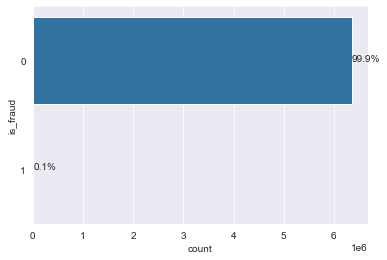

The ratio of fraud to non-fraud is:
0    6354407
1       8213
Name: is_fraud, dtype: int64


In [8]:
# Plot target variable
sns.set_style('darkgrid')
# Check helper functio subsection
percentual_count('is_fraud', df2)

print('The ratio of fraud to non-fraud is:')
print(df2.is_fraud.value_counts())

* 0.1% of transactions are fraudulent
* The dataset is imbalanced.

### 4.2.2. Numerical Variables Distribution

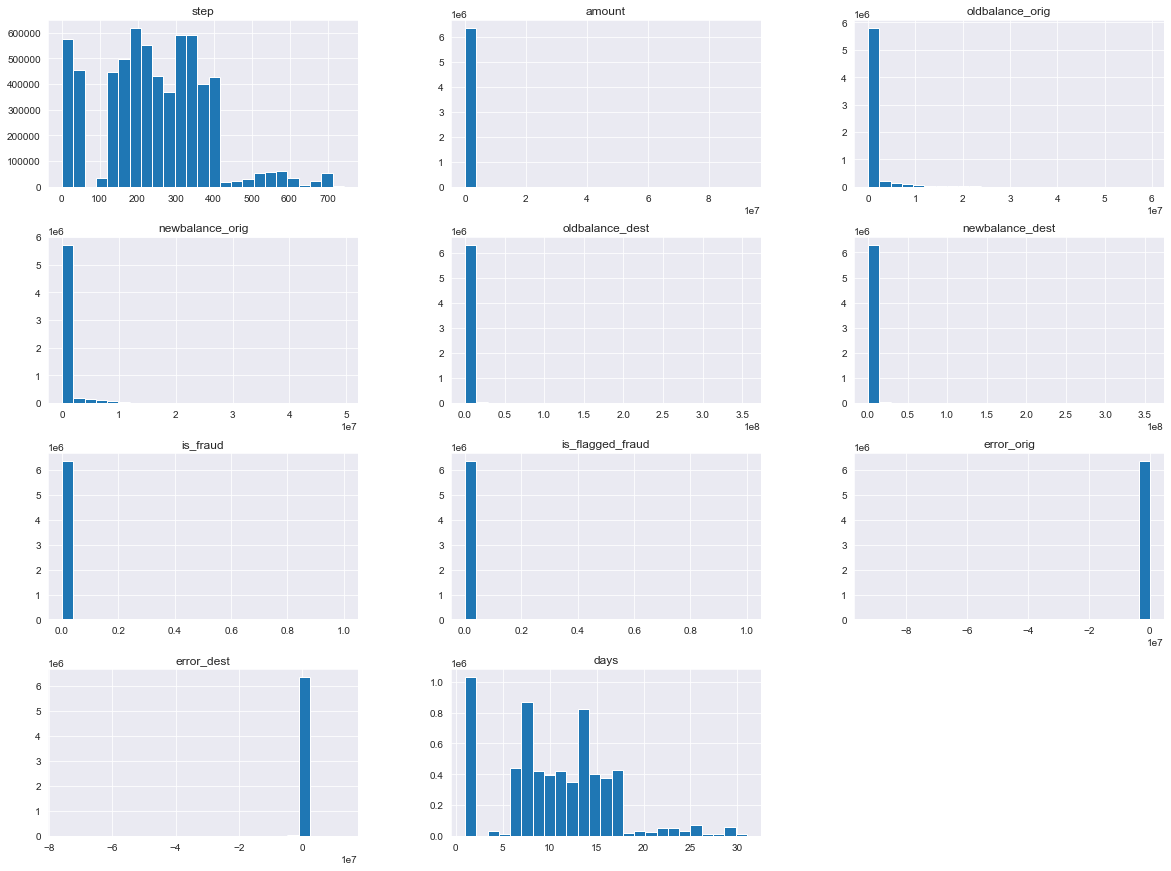

In [9]:
# Selecting Numerical features
numerical_df2 = df2.select_dtypes(exclude=['object', 'category'])

# Plot numerical
numerical_df2.hist(figsize=(20,15), bins=25)
plt.show()

* Some graphics are difficult to view. To solve this we will use log normalize
* `oldbalance_orig` and `newbalance_orig` are right skewed
* High outliers influence

In [58]:
# Log transformation
numerical_cols = numerical_df2.columns
numerical_log_df2 = numerical_df2

for i in range(len(numerical_cols)):
    numerical_log_df2.loc[i] = numerical_log_df2.loc[i].apply(lambda x: 0 if x==0 else np.log1p(x))

# Fill NaN values
numerical_log_df2=numerical_log_df2.fillna(0)

,step,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_orig,error_dest,days
0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743.0,1.286475,1.286475,0.0,0.000000,2.620003,1.0,0.0,-0.005025,0.004975,31.0
6362616,743.0,1.338386,1.338386,0.0,0.000000,0.000000,1.0,0.0,0.000000,2.812883,31.0
6362617,743.0,1.338386,1.338386,0.0,2.496048,2.813530,1.0,0.0,0.000000,0.256710,31.0
6362618,743.0,1.304174,1.304174,0.0,0.000000,0.000000,1.0,0.0,0.000000,2.684645,31.0


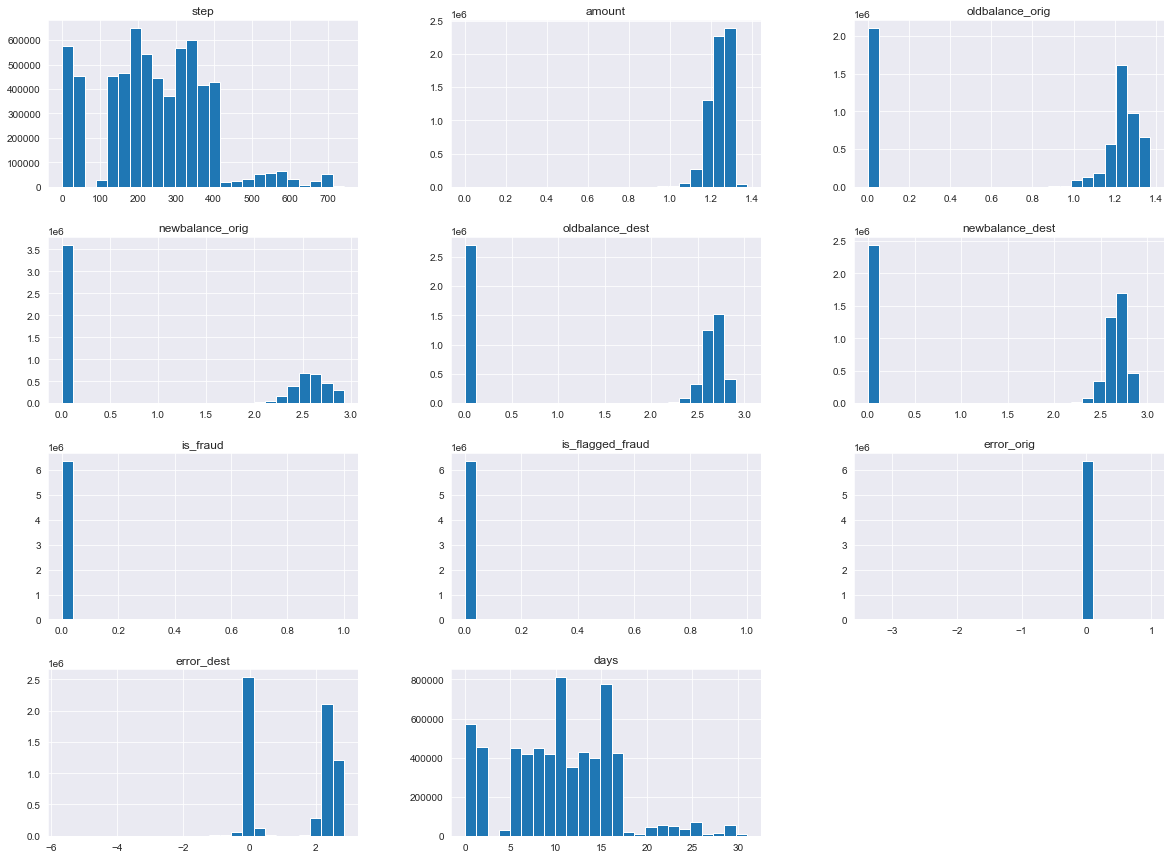

In [60]:
# Plot Numerical features log
numerical_log_df2.hist(figsize=(20,15), bins=25)
plt.show()


### 4.2.2. Categorical Variable

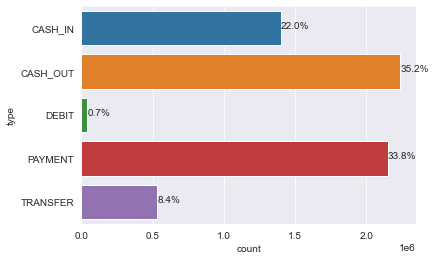

In [61]:
# Selecting categorical features
cat_attr = df2.select_dtypes(include=['object', 'category'])

# Countplot
percentual_count('type', cat_attr)
plt.show()

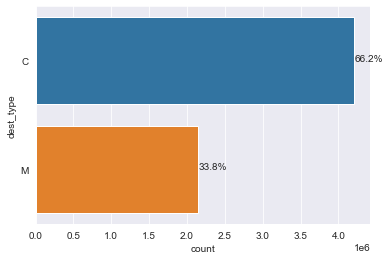

In [62]:
# Checking customer
percentual_count('dest_type', cat_attr)
plt.show()

## 4.3. Bivariate Analysis

### H1. Frauds occur with 3 types of transfers.
**FALSE**: There's only two types of fraudulent transactions: `CASH_OUT` and `TRANSFER`.

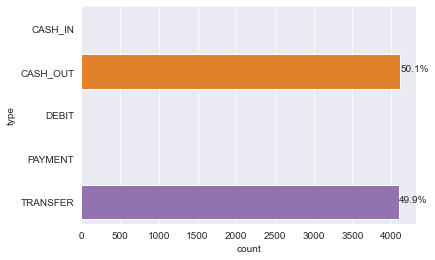

In [63]:
# Dataset with fraudulent transactions
h1 = df2[df2.is_fraud == 1]

# Countplot fraudulent types
percentual_count('type', h1)
plt.show()

### H2. Fraud occur with low values amounts.
**TRUE**: Fraudulent transactions occur more frequently at lower amounts

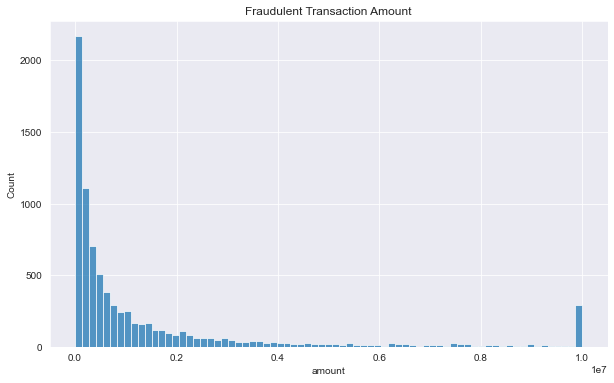

In [64]:
# Histplot fraud amount
plt.figure(figsize=(10, 6))
sns.histplot(data=h1.amount)
plt.title('Fraudulent Transaction Amount')
plt.show()

### H3. Fraud occur with high values of old balance origin.
**TRUE**: Fraud occur with high values, but on a smaller scale.

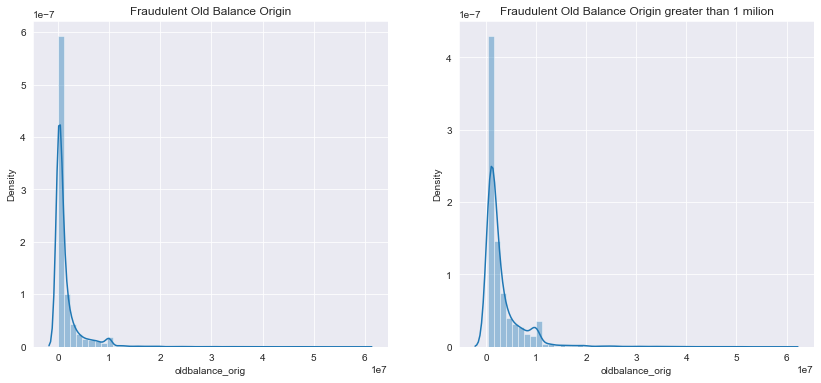

In [75]:
# Histplot fraud old balance origin
plt.figure(figsize=(14, 6))

# Histplot for old balance origin
plt.subplot(1,2,1)
sns.distplot(h1.oldbalance_orig)
plt.title('Fraudulent Old Balance Origin')

# Histplot for high value old balance origin
plt.subplot(1,2,2)
sns.distplot(h1[h1.oldbalance_orig > 5e5]['oldbalance_orig'])
plt.title('Fraudulent Old Balance Origin greater than 1 milion')
plt.show()

### H4. Fraud occur with new balance origin is equal zero.
**TRUE**: Fraud generally occur when the New Balance Origin is equal zero.

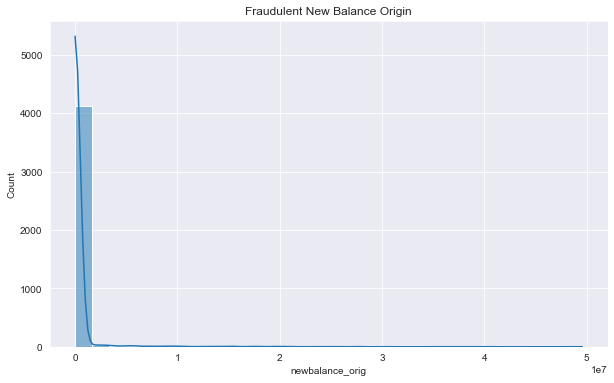

In [76]:
plt.figure(figsize=(10,6))
sns.histplot(h1.newbalance_orig[h1.oldbalance_orig > 4e5], kde=True, bins=30)
plt.title('Fraudulent New Balance Origin')
plt.show()

### H5. Fraud occur with low values old balance destination.
**TRUE**

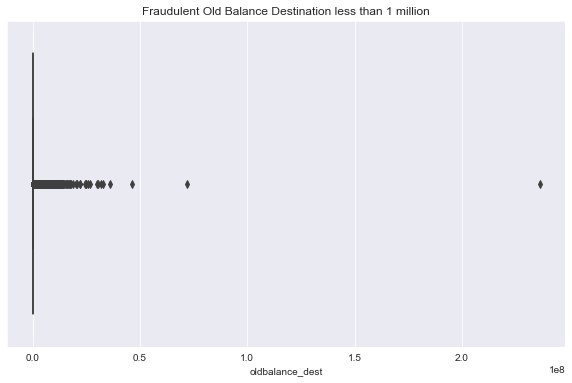

In [78]:
plt.figure(figsize=(10,6))
sns.boxplot(h1.oldbalance_dest)
plt.title('Fraudulent Old Balance Destination less than 1 million')
plt.show()

### H6. All fraudulent transaction occur with new receiver balance equal zero.
**FALSE**: Some balance destination are greater than zero.

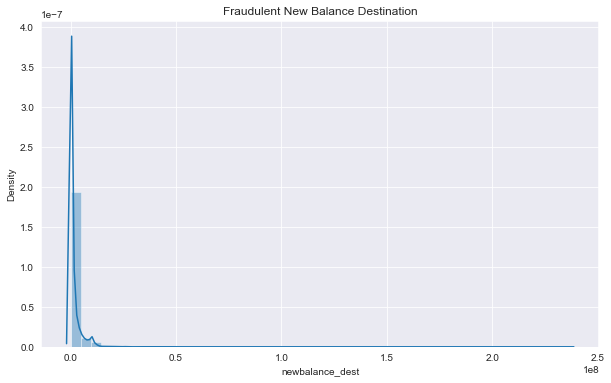

In [68]:
plt.figure(figsize=(10,6))
sns.distplot(h1.newbalance_dest)
plt.title('Fraudulent New Balance Destination')
plt.show()

### H7. Customer to customer transactions represent 50% of the total fraudulent transactions.
**FALSE**: 100% of fraudulent transactions are customer-to-customer.

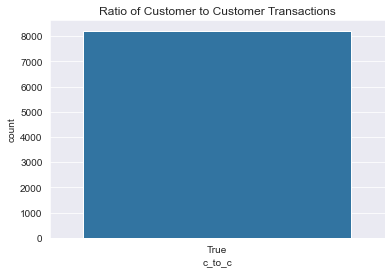

In [69]:
# Customer feature with initial letter
h1['origin_type'] = h1.name_orig.str.replace(r'[0-9]', regex=True, repl='')

# True if customer to customer
c_to_c = (h1.origin_type == h1.dest_type)

# Creating column customer to customer
h1['c_to_c'] = c_to_c

# Plot bar
sns.countplot(data=h1, x='c_to_c')
plt.title('Ratio of Customer to Customer Transactions')
plt.show()

### H8. Merchant receiver represents 40% of the total fraudulent transactions.
**FALSE**: None of fraudulent transactions are for merchants.

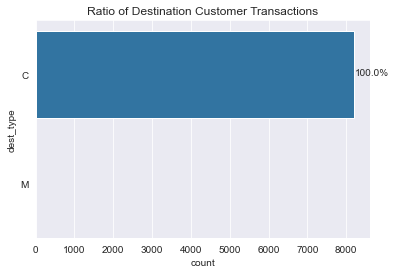

In [70]:
plt.title('Ratio of Destination Customer Transactions')
percentual_count('dest_type', h1)
plt.show()

### H9. Most Fraud occurs between days 10 and 20.
**FALSE**: Fraud occur between days 20 and 31.

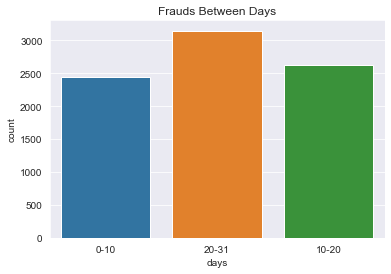

In [85]:
sns.countplot(h1.days.apply(lambda x: '0-10' if x < 10 else ('10-20' if 10 < x < 21 else '20-31' )))
plt.title('Frauds Between Days')
plt.show()

### H10. All flagged frauds represent 90% of frauds transactions.
**FALSE**: 0.2% of the total fraudulent transactions are flagged as fraud.

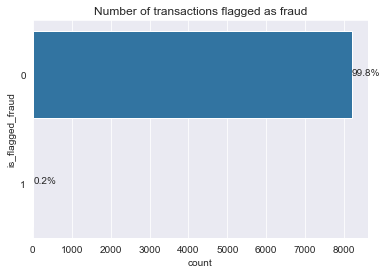

In [72]:
plt.title('Number of transactions flagged as fraud')
percentual_count('is_flagged_fraud', h1)
plt.show()

### 4.3.1. Hypotheses summary

| #    | HYPOTHESES                                                   | CONCLUSION |
| ---- | ------------------------------------------------------------ | :--------- |
| h1   | Frauds occur with 3 types of transfers.                      | FALSE       |
| h2   | Fraud occur with low values amounts.                         | TRUE       |
| h3   | Fraud occur with high values of old origin balance.          | TRUE       |
| h4   | Fraud occur with new balance origin is equal zero.           | TRUE       |
| h5   | Fraud occur with low values old balance destination.         | TRUE       |
| h6   | All fraudulent transaction occur with new receiver balance equal zero. | FALSE      |
| h7   | Customer to customer transactions represent 50% of the total fraudulent transactions. | FALSE      |
| h8   | Merchant receiver represents 40% of the total fraudulent transactions. | FALSE      |
| h9   | Fraud occurs after the 10th.                                 | FALSE      |
| h10  | All flagged frauds represent 90% of fraud transactions.      | FALSE      |

## 4.4. Multivariate Analysis

### 4.4.1. Numerical Variables

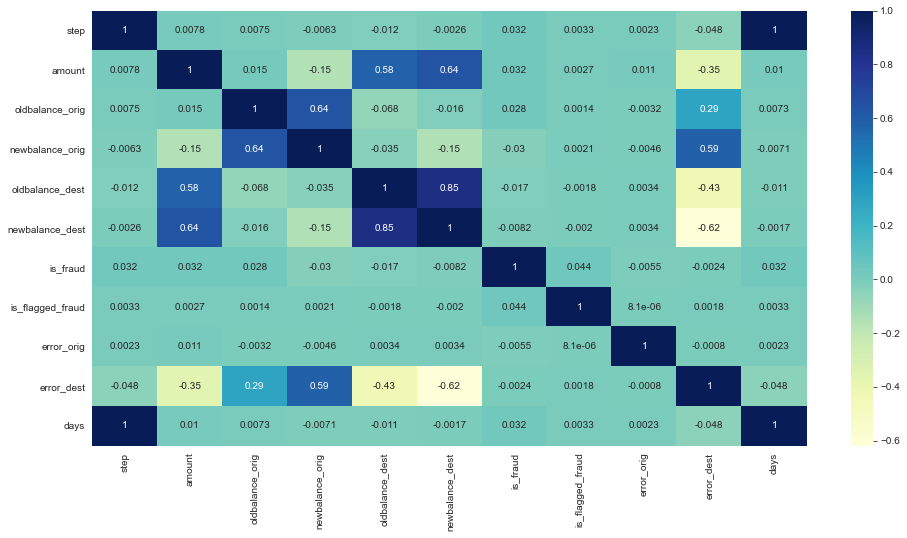

In [73]:
plt.figure(figsize=(16,8))
sns.heatmap(numerical_df2.corr(), annot=True, cmap='YlGnBu')
plt.show()

### 4.4.2. Categorical Variables

Using Panda's Profiling to visualize the correlation between categorical variables, the Cramér's V is an association measure for nominal random variables. The coefficient ranges from 0 to 1, with 0 indicating independence and 1 indicating perfect association.

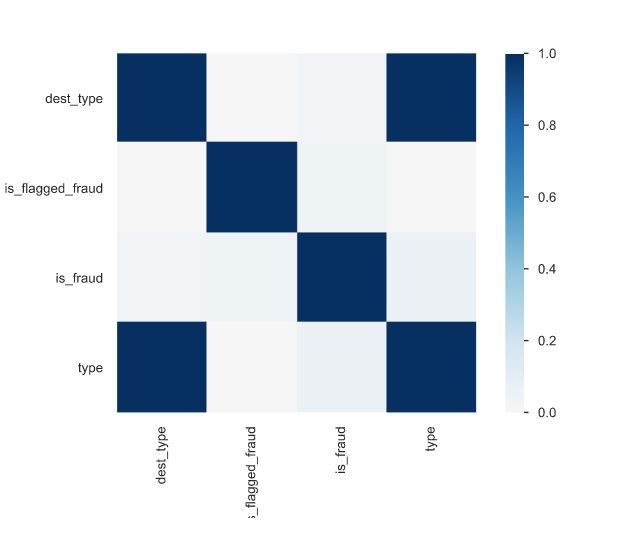

In [74]:
Image('image\crammer.JPG')

# 5.0. Data Preparation 

In [2]:
# Load dataset
feature_dtypes = {'step': 'int16',
                  'type': 'category',
                  'amount': 'float32',
                  'name_orig': 'object',
                  'oldbalance_orig': 'float32',
                  'newbalance_orig': 'float32',
                  'name_dest': 'object',
                  'oldbalance_dest': 'float32',
                  'newbalance_dest': 'float32',
                  'is_fraud': 'uint8',
                  'is_flagged_fraud': 'uint8',
                  'error_orig' : 'float32',
                  'error_dest' : 'float32',
                  'dest_type' : 'category',
                  'days' : 'int8'}

df2 = pd.read_csv('dataset\df2.csv', dtype=feature_dtypes)

## 5.1. Transformation

In [3]:
df3 = df2.copy()

In [4]:
types_col = {
    'CASH_IN' : 0,
    'CASH_OUT' : 1, 
    'DEBIT': 2,
    'PAYMENT': 3,
    'TRANSFER': 4}
dest_type = {
    'C': 0,
    'M': 1}

df3.type = df3.type.map(types_col)
df3.dest_type = df3.dest_type.map(dest_type)

## 5.2. Rescaling

In [5]:
# Min - Max Scaler
mms = MinMaxScaler()
df3.step = mms.fit_transform(df3[['step']].values)
df3.days = mms.fit_transform(df3[['days']].values)

In [6]:
# Robust Scaler
rs = RobustScaler()
cols_for_robust = ['amount', 'oldbalance_orig', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest' ]

for i in cols_for_robust:
    df3[i] = rs.fit_transform(df3[[i]].values) 

## 5.3. Standardization

None of the numerical variables have a normal distribution.

# 6.0. Feature Selection

## 6.1. Drop and Split Columns

In [7]:
# Removing unnecessary columns
df3 = df3.drop(['name_orig', 'name_dest'], axis = 1)

# Variables
X_feature = df3.drop('is_fraud', axis=1)

# Target variable
Y_feature = df3.is_fraud

## 6.2. Feature Importance

[0.02440702 0.02840301 0.08756767 0.05702182 0.36723484 0.02453286
 0.07278183 0.00060539 0.22264835 0.09397743 0.00223826 0.01858151]


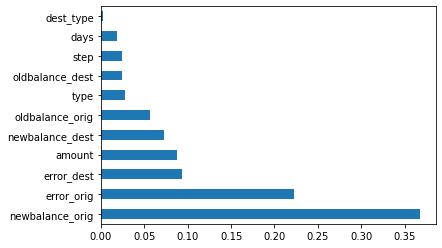

In [8]:
# Selecting Model
model = RandomForestClassifier()
model.fit(X_feature, Y_feature)

# Use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_)
 
# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_feature.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

## 6.3. Boruta

In [9]:
# Train using random forest classifier

# X train
X_boruta = X_feature.values

# Y train
Y_boruta = Y_feature.values

# Define random forest classifier
rf = RandomForestClassifier(n_estimators=200, n_jobs=4, max_depth = 6, class_weight='balanced')

# Define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_boruta, Y_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	0


### 6.3.1. Best features

In [10]:
# Check selected features
cols_selected_boruta = feat_selector.support_.tolist()
columns_selected = df3.drop(['is_fraud'], axis=1).loc[:, cols_selected_boruta].columns.tolist()
columns_selected

['step',
 'type',
 'amount',
 'oldbalance_orig',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'is_flagged_fraud',
 'error_orig',
 'error_dest',
 'dest_type',
 'days']

In [11]:
# Saving datase
df3.to_csv('dataset\df3.csv', index=False)

# 7.0. Machine Learning Modeling 

In [5]:
# Load dataset
feature_dtypes = {'step': 'float32',
                  'type': 'uint8',
                  'amount': 'float32',
                  'oldbalance_orig': 'float32',
                  'newbalance_orig': 'float32',
                  'oldbalance_dest': 'float32',
                  'newbalance_dest': 'float32',
                  'is_fraud': 'uint8',
                  'is_flagged_fraud': 'uint8',
                  'error_orig' : 'float32',
                  'error_dest' : 'float32',
                  'dest_type' : 'uint8',
                  'days' : 'float32'}


df3 = pd.read_csv('dataset\df3.csv', dtype=feature_dtypes)

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              float32
 1   type              uint8  
 2   amount            float32
 3   oldbalance_orig   float32
 4   newbalance_orig   float32
 5   oldbalance_dest   float32
 6   newbalance_dest   float32
 7   is_fraud          uint8  
 8   is_flagged_fraud  uint8  
 9   error_orig        float32
 10  error_dest        float32
 11  dest_type         uint8  
 12  days              float32
dtypes: float32(9), uint8(4)
memory usage: 242.7 MB


In [7]:
# Boruta feature
boruta_select = ['step',
 'type',
 'amount',
 'oldbalance_orig',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'is_flagged_fraud',
 'error_orig',
 'error_dest',
 'dest_type',
 'days']

## 7.1. Spliting Into Train, Valid and Test

In [8]:
df4 = df3.copy()

# Remove target variable from train set
X = df4[boruta_select]
Y = df4.is_fraud

# Spliting
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 47)

In [9]:
# Since Data Set is imbalanced, SMOTE will apply_train to balance representatoin of Response feature
print("Shape of x_train before over-Sampling:", x_train.shape)
print("Shape of y_train before over-Sampling:", y_train.shape)
print("---" * 15)
print('Proportion of target variable before over-Sampling:')
print(y_train.value_counts())

# SMOTE
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

print("Shape of x_train after over-Sampling:", x_train.shape)
print("Shape of y_train after over-Sampling:", y_train.shape)
print("---" * 15)
print('Proportion of target variable after over-Sampling:')
print(y_train.value_counts())

Shape of x_train before over-Sampling: (5090096, 12)
Shape of y_train before over-Sampling: (5090096,)
---------------------------------------------
Proportion of target variable before over-Sampling:
0    5083488
1       6608
Name: is_fraud, dtype: int64
Shape of x_train after over-Sampling: (10166976, 12)
Shape of y_train after over-Sampling: (10166976,)
---------------------------------------------
Proportion of target variable after over-Sampling:
1    5083488
0    5083488
Name: is_fraud, dtype: int64


## 7.2. Baseline: Dummy Classifier

In [10]:
# Model and fit
dummy = DummyClassifier().fit(x_train, y_train)

# Predicting
y_pred = dummy.predict(x_test)

### 7.2.1. Baseline performance

In [11]:
Dummy_performance = ml_scores('Baseline', y_test, y_pred)
Dummy_performance

,Accuracy,Precision,Recall,F1,ROC
Baseline,0.499483,0.00125,0.49595,0.002493,0.497719


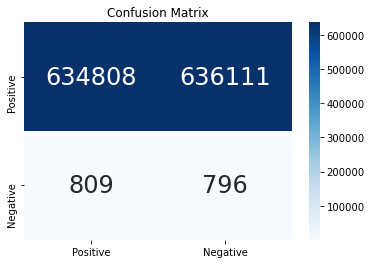

In [12]:
conf_matrix(y_test, y_pred)

## 7.3. Logistic Regression

### 7.3.1. Logistic Regression model fit

In [13]:
# Model and fit
lr = LogisticRegression().fit(x_train, y_train)

# Predicting
y_pred_lr = lr.predict(x_test)

### 7.3.2. Logistic Regression performance

In [14]:
performance_lr = ml_scores('Logistic Regression', y_test, y_pred_lr)
performance_lr

,Accuracy,Precision,Recall,F1,ROC
Logistic Regression,0.960864,0.02749,0.87352,0.053303,0.917247


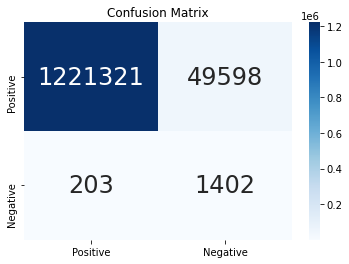

In [15]:
conf_matrix(y_test, y_pred_lr)

## 7.4. Random Forest Classifier

### 7.4.1. Random Forest Classifier model and fit

In [18]:
# Model and fit
rfc = RandomForestClassifier().fit(x_train, y_train)

# Predicting
y_pred_rfc = rfc.predict(x_test)

### 7.4.2. Random Forest Classifier performance

In [19]:
rfc_performance = ml_scores('Random Forest', y_test, y_pred_rfc)
rfc_performance

,Accuracy,Precision,Recall,F1,ROC
Random Forest,0.999992,0.997505,0.996262,0.996883,0.998129


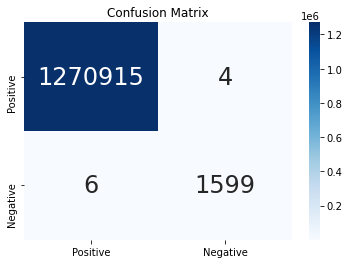

In [20]:
conf_matrix(y_test, y_pred_rfc)

## 7.5. XGBoost Classifier

### 7.5.1. XGBoost Classifier model and fit

In [21]:
xgb = XGBClassifier().fit(x_train, y_train)

# Predicting
y_pred_xgb = xgb.predict(x_test)

[13:13:21] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


### 7.5.2. XGBoost Classifier performance

In [22]:
xgb_performance = ml_scores('XGBoost Classifier', y_test, y_pred_xgb)
xgb_performance

,Accuracy,Precision,Recall,F1,ROC
XGBoost Classifier,0.999939,0.95746,0.995639,0.976176,0.997791


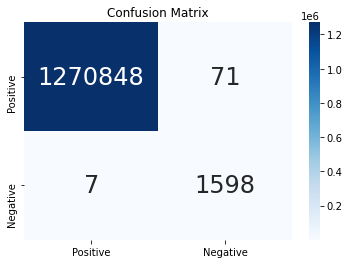

In [23]:
conf_matrix(y_test, y_pred_xgb)

## 7.6. Results

In [24]:
performance = pd.concat([Dummy_performance, performance_lr, rfc_performance, xgb_performance])
performance

,Accuracy,Precision,Recall,F1,ROC
Baseline,0.499483,0.001250,0.495950,0.002493,0.497719
Logistic Regression,0.960864,0.027490,0.873520,0.053303,0.917247
Random Forest,0.999994,0.998751,0.996262,0.997505,0.998130
XGBoost Classifier,0.999939,0.957460,0.995639,0.976176,0.997791


# 8.0. Cross Validation

## 8.1. Logistic Regression

In [28]:
lr_cv = cross_val_performance(lr, x_train, y_train)
lr_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9164 +/- 0.0045,0.9447 +/- 0.0277,0.8851 +/- 0.038,0.9136 +/- 0.0076,0.9164 +/- 0.0045


## 8.2. Random Forest Classifier

In [21]:
rfc_cv = cross_val_performance(rfc, x_train, y_train)
rfc_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9999903609499077 +/- 1.4802377865535678e-05,0.9999954755527607 +/- 1.1440221213433658e-05,0.9999852463528592 +/- 3.104806475030822e-05,0.9999903608527762 +/- 1.4802823138185764e-05,0.9999903609504882 +/- 1.4802376916999629e-05


## 8.3. XGBoost Classifier

In [30]:
xgb_cv = cross_val_performance(xgb, x_train, y_train)
xgb_cv

[21:52:30] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[22:17:44] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[22:43:27] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[23:10:07] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[23:41:02] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_meth

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9985 +/- 0.0002,0.9999 +/- 0.0,0.9971 +/- 0.0003,0.9985 +/- 0.0002,0.9985 +/- 0.0002


## 8.4. Results

In [31]:
index = ['Logistic Regression', 'Random Forest Classifier', 'XGBoost Classifier']

performance_cv = pd.concat([lr_cv, rfc_cv, xgb_cv])
performance_cv.index = index
performance_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
Logistic Regression,0.9164 +/- 0.0045,0.9447 +/- 0.0277,0.8851 +/- 0.038,0.9136 +/- 0.0076,0.9164 +/- 0.0045
Random Forest Classifier,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0
XGBoost Classifier,0.9985 +/- 0.0002,0.9999 +/- 0.0,0.9971 +/- 0.0003,0.9985 +/- 0.0002,0.9985 +/- 0.0002


In [34]:
# Saving Best models

# Random Forest
pickle.dump(rfc, open('models/rfc.pkl', 'wb'))


# XGBoost
pickle.dump(xgb, open('models/xgb.pkl', 'wb'))

# 9.0. Hyperparameter Fine Tuning

In [19]:
# Load Machine Learning Models
rfc = pickle.load(open('models/rfc.pkl', 'rb'))

## 9.1. GridSearchCV

In [20]:
# Parameters
parameters = { 
    'n_estimators': np.arange(10, 105, 30),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(2, 12, 4),
    'criterion' :['gini', 'entropy']
}

rfc_tunned = GridSearchCV(
    estimator=rfc,
    param_grid=nuparameters,
    scoring = 'f1',
    verbose=2,
    n_jobs = -1 )
rfc_tunned.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 476.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 1319.2min finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 2,  6, 10]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([ 10,  40,  70, 100])},
             scoring='f1', verbose=2)

In [21]:
rfc_tunned.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 10}

In [ ]:
best_param = {'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 10}

# 10.0. Final Model

## 10.1. Random Forest Classifier +

In [12]:
# Model and fit
rfc_tunned = RandomForestClassifier(
    criterion = 'entropy',
    max_depth = 10,
    max_features = 'sqrt',
    n_estimators = 10
).fit(x_train, y_train)

# Predict
y_pred_rfc_t = rfc_tunned.predict(x_test)

### 10.1.1. Random Forest Classifier + Performance

In [14]:
# Performance
rfc_tunned_performance = ml_scores('Random Forest', y_test, y_pred_rfc_t)
rfc_tunned_performance

,Accuracy,Precision,Recall,F1,ROC
Random Forest,0.999991,0.996883,0.996262,0.996572,0.998129


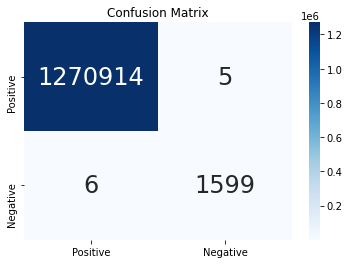

In [15]:
# Cofusion matrix
conf_matrix(y_test, y_pred_rfc_t)


### 10.1.2. Cross validation tunned version

In [17]:
# Cross validation
rfc_tunned_cv = cross_val_performance(rfc_tunned, x_train, y_train)
rfc_tunned_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9986719747882166 +/- 0.000349312854856119,0.9999934920379937 +/- 9.30282963761035e-06,0.9973504412260782 +/- 0.0007037845131346804,0.9986701894925369 +/- 0.00035021496632904007,0.9986719748110474 +/- 0.00034931241906775045


In [26]:
pickle.dump(rfc_tunned, open('models/rfc_tunned.pkl', 'wb'))

# 11.0. Business Performance

In [2]:
# Load dataset
feature_dtypes = {'step': 'float32',
                  'type': 'uint8',
                  'amount': 'float32',
                  'oldbalance_orig': 'float32',
                  'newbalance_orig': 'float32',
                  'oldbalance_dest': 'float32',
                  'newbalance_dest': 'float32',
                  'is_fraud': 'uint8',
                  'is_flagged_fraud': 'uint8',
                  'error_orig' : 'float32',
                  'error_dest' : 'float32',
                  'dest_type' : 'uint8',
                  'days' : 'float32'}


df4 = pd.read_csv('dataset\df3.csv', dtype=feature_dtypes)

In [28]:
# Load dataset 2
# Load dataset
feature_dtypes = {'step': 'int16',
                  'type': 'category',
                  'amount': 'float32',
                  'name_orig': 'object',
                  'oldbalance_orig': 'float32',
                  'newbalance_orig': 'float32',
                  'name_dest': 'object',
                  'oldbalance_dest': 'float32',
                  'newbalance_dest': 'float32',
                  'is_fraud': 'uint8',
                  'is_flagged_fraud': 'uint8',
                  'error_orig' : 'float32',
                  'error_dest' : 'float32',
                  'dest_type' : 'category',
                  'days' : 'int8'}

df5 = pd.read_csv('dataset\df2.csv', dtype=feature_dtypes)

In [4]:
# Machine Learning featuers
boruta_select = ['step',
 'type',
 'amount',
 'oldbalance_orig',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'is_flagged_fraud',
 'error_orig',
 'error_dest',
 'dest_type',
 'days']

In [3]:
# Load Machine Learning Models
rfc_tunned = pickle.load(open('models/rfc_tunned.pkl', 'rb'))

## 11.1. What is the model's *precision* and *accuracy*?

### 11.1.1. Performance

In [6]:
df_results = pd.read_csv('dataset/results.csv')
df_results

,NAME,ACCURACY,PRECISION,RECALL,F1,ROC
0,Baseline,0.499483,0.001250,0.495950,0.002493,0.497719
1,Logistic Regression,0.960864,0.027490,0.873520,0.053303,0.917247
2,Random Forest,0.999994,0.998751,0.996262,0.997505,0.998130
3,XGBoost Classifier,0.999939,0.957460,0.995639,0.976176,0.997790
4,Random Forest+,0.999991,0.996883,0.996262,0.996572,0.998129


## 11.2. How reliable is the model in classifying transactions as *legitimate* or *fraudulent*?

### 11.2.1. Real Performance

In [7]:
df_r_results = pd.read_csv('dataset/real_results.csv')
df_r_results

,real_accuracy,std_accuracy,real_precision,std_precision,real_recall,std_recall,real_f1,std_f1,real_roc,std_roc
Logistic Regression,0.9164,0.0045,0.9447,0.0277,0.8851,0.0380,0.9136,0.0076,0.9164,0.0045
Random Forest Classifier,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000
XGBoost Classifier,0.9985,0.0002,0.9999,0.0000,0.9971,0.0003,0.9985,0.0002,0.9985,0.0002
Random Forest Classifier+,0.9987,0.0003,1.0000,0.0000,0.9974,0.0007,0.9987,0.0004,0.9987,0.0003


## 11.3.  What is the expected billing by the company if we classify 100% of data transactions with the model?

In [37]:
# Predict column
df4['predict'] = rfc_tunned.predict(df4[boruta_select])
df5['predict'] = df4.predict

# The company receive 25% of each transaction value truly detected as fraud
correct_predict = df5[(df5.is_fraud == 1) & (df5.predict == 1)]
correct_predict_amount = correct_predict[['amount', 'is_fraud', 'predict']].groupby(['is_fraud', 'predict']).sum().reset_index()
correct_predict_amount['to_receive'] = correct_predict_amount.amount * 0.25
amount_TP = correct_predict_amount.to_receive.sum()
print(f'The company will receive ${amount_TP:,.2f} dua to transaction truly detected as fraud')
print('---' * 30)

# The company will receive 5% of the value of each transaction detected as fraud, but the transaction is legitimate
not_fraud = df5[(df5.is_fraud == 0) & (df5.predict == 1)]
not_fraud_amount = not_fraud[['amount', 'is_fraud', 'predict']].groupby(['is_fraud', 'predict']).sum().reset_index()
not_fraud_amount['to_receive'] = not_fraud_amount.amount * 0.05
amount_FP = not_fraud_amount.to_receive.sum()
print(f'The company will receive ${amount_FP:,.2f} due to transaction detected as fraud, but actually legitimate')

The company will receive $3,011,586,048.00 dua to transaction truly detected as fraud
------------------------------------------------------------------------------------------
The company will receive $421,231.81 due to transaction detected as fraud, but actually legitimate


In [39]:
expected_bill = amount_TP + amount_FP
print(f'The expected billing by the company if we classify 100% of data transactions is: ${expected_bill:,.2f}')

The expected billing by the company if we classify 100% of data transactions is: $3,012,007,168.00


## 11.4. What is the loss expected by company in case of model failure?

In [40]:
# The company will return 100% of the value to the customer, for each transaction detected as legitimate, however a transaction is a fraud
wrong_predict = df5[(df5.is_fraud == 1) & (df5.predict == 0)]
wrong_predict_amount = wrong_predict[['amount', 'is_fraud', 'predict']].groupby(['is_fraud', 'predict']).sum().reset_index()
wrong_predict_amount['to_receive'] = wrong_predict_amount.amount * 1
amount_TF = wrong_predict_amount.to_receive.sum()
print(f'The company will give back ${amount_TF:,.2f} due to transactions detected as legitimate, but actually fraud')

The company will give back $10,071,736.00 due to transactions detected as legitimate, but actually fraud


## 11.5. What is the profit expected by the Blocker Fraud Company when using model?

In [41]:
profit = expected_bill - amount_TF
print(f'The profit of Blocker Fraud Company is: ${profit:,.2f}')

The profit of Blocker Fraud Company is: $3,001,935,360.00


# 12.0. Merging Notebooks

## 12.1.  View .ipynb file contents

In [ ]:
import json
import os

# note -- we can look at a .ipynb file as a plain text file right here in Jupyter notebook
with open ('part1_blocker_fraud.ipynb', mode = 'r', encoding = 'utf-8') as f:
    a = json.load (f)

print(type(a))

print(a.keys())

print(a)

## 12.2. Generating List of Notebooks to Merge

In [2]:
# generate list of files to be merged
notebooks_to_merge = [file for file in os.listdir(os.getcwd()) if file.endswith('.ipynb')]

# list should be in the order in which you want the notebooks to be merged
# my notebooks are labeled 1.ipynb, 2.ipynb... in the order I want
notebooks_to_merge.sort()

print(notebooks_to_merge)

['part1_blocker_fraud.ipynb', 'part2_blocker_fraud.ipynb', 'part3_blocker_fraud.ipynb', 'part4_blocker_fraud.ipynb', 'part5_blocker_fraud.ipynb', 'part6_blocker_fraud.ipynb', 'v003_blocker_fraud_co.ipynb']


## 12.3. Generate Combined .ipynb File

In [ ]:
def combine_ipynb_files(list_of_notebooks, combined_file_name):
    
    '''
    parameters:
    `list_of_notebooks` is an ordered list of your .ipynb files to be merged
    `combined_file_name` is the name of your combined .ipynb file which will be generated by this function
    
    returns: the filepath of the new file
    '''
    
    with open (notebooks_to_merge[0], mode = 'r', encoding = 'utf-8') as f:
        a = json.load (f)
    
    for notebook in notebooks_to_merge[1:]:
        with open (notebook, mode = 'r', encoding = 'utf-8') as f:
            b = json.load(f)
            a['cells'].extend (b['cells']) 
                # extend here, not append, so that each dictionary in b['cells']
                # is added to new dictionary in a['cells']

    with open(combined_file_name, mode='w', encoding='utf-8') as f:
        json.dump(a, f)
    
    print('Generated file: "{}".'.format(combined_file_name))
    
    return (os.path.realpath(combined_file_name))

combine_ipynb_files(notebooks_to_merge, "ver001_blocker_fraud.ipynb")